In [1]:
# ============================================================
# Imports & Device
# ============================================================

import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
# ============================================================
# CBAM Modules
# ============================================================

class ChannelAttention(nn.Module):
    def __init__(self, c: int, r: int = 16):
        super().__init__()
        mid = max(1, c // r)
        self.mlp = nn.Sequential(
            nn.Conv2d(c, mid, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid, c, 1, bias=False),
        )

    def forward(self, x):
        avg = torch.mean(x, dim=(2, 3), keepdim=True)
        mx = torch.amax(x, dim=(2, 3), keepdim=True)
        att = torch.sigmoid(self.mlp(avg) + self.mlp(mx))
        return x * att

class SpatialAttention(nn.Module):
    def __init__(self, k: int = 7):
        super().__init__()
        p = (k - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=k, padding=p, bias=False)

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        mx = torch.amax(x, dim=1, keepdim=True)
        att = torch.sigmoid(self.conv(torch.cat([avg, mx], dim=1)))
        return x * att

class CBAM(nn.Module):
    def __init__(self, c: int):
        super().__init__()
        self.ca = ChannelAttention(c)
        self.sa = SpatialAttention()

    def forward(self, x):
        return self.sa(self.ca(x))


In [3]:
# ============================================================
# Backbone + FPN + Model
# ============================================================

class ResNetBackboneCBAM(nn.Module):
    def __init__(self, name="resnet50", pretrained=True):
        super().__init__()

        weights = models.ResNet50_Weights.DEFAULT if pretrained else None
        base = models.resnet50(weights=weights)

        self.conv1 = base.conv1
        self.bn1 = base.bn1
        self.relu = base.relu
        self.maxpool = base.maxpool

        self.layer1 = base.layer1
        self.layer2 = base.layer2
        self.layer3 = base.layer3
        self.layer4 = base.layer4

        self.cbam2 = CBAM(256)
        self.cbam3 = CBAM(512)
        self.cbam4 = CBAM(1024)
        self.cbam5 = CBAM(2048)

        self.out_channels = (256, 512, 1024, 2048)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        c2 = self.cbam2(self.layer1(x))
        c3 = self.cbam3(self.layer2(c2))
        c4 = self.cbam4(self.layer3(c3))
        c5 = self.cbam5(self.layer4(c4))

        return {"c2": c2, "c3": c3, "c4": c4, "c5": c5}


class FPN(nn.Module):
    def __init__(self, in_channels, fpn_channels=256):
        super().__init__()
        c2, c3, c4, c5 = in_channels
        self.l2 = nn.Conv2d(c2, fpn_channels, 1)
        self.l3 = nn.Conv2d(c3, fpn_channels, 1)
        self.l4 = nn.Conv2d(c4, fpn_channels, 1)
        self.l5 = nn.Conv2d(c5, fpn_channels, 1)

        self.s2 = nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1)
        self.s3 = nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1)
        self.s4 = nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1)
        self.s5 = nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1)

    def forward(self, feats):
        c2, c3, c4, c5 = feats.values()
        p5 = self.l5(c5)
        p4 = self.l4(c4) + F.interpolate(p5, size=c4.shape[-2:], mode="nearest")
        p3 = self.l3(c3) + F.interpolate(p4, size=c3.shape[-2:], mode="nearest")
        p2 = self.l2(c2) + F.interpolate(p3, size=c2.shape[-2:], mode="nearest")
        return {"p2": self.s2(p2), "p3": self.s3(p3), "p4": self.s4(p4), "p5": self.s5(p5)}

class ConvHead(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, out_ch, 1)
        )

    def forward(self, x):
        return self.net(x)

class ShelfScoutPanopticCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = ResNetBackboneCBAM()
        self.fpn = FPN(self.backbone.out_channels)

        self.sem_head = ConvHead(256, 2)
        self.ctr_head = ConvHead(256, 1)
        self.off_head = ConvHead(256, 2)

    def forward(self, x):
        feats = self.backbone(x)
        p2 = self.fpn(feats)["p2"]
        return self.sem_head(p2), self.ctr_head(p2), self.off_head(p2)



In [4]:
# ============================================================
# Load Trained Model
# ============================================================

model = ShelfScoutPanopticCNN().to(device)

ckpt = torch.load("checkpoints/shelfscout_latest.pth", map_location=device)
model.load_state_dict(ckpt["model_state"])

model.eval()
print("Checkpoint loaded successfully")


C:\Users\Mohammad\AppData\Local\Temp\ipykernel_6088\552542387.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("checkpoints/shelfscout_latest.pth", map_

Checkpoint loaded successfully


In [5]:
# ============================================================
# Post-Processing Utilities (UNCHANGED)
# ============================================================

STRIDE = 4 # DO NOT CHANGE


def decode_centers(ctr_logits, stride, prob_thresh=0.3, nms_kernel=3, top_k=200):
    B, _, Hf, Wf = ctr_logits.shape
    ctr_probs = torch.sigmoid(ctr_logits)

    pooled = F.max_pool2d(
        ctr_probs,
        kernel_size=nms_kernel,
        stride=1,
        padding=nms_kernel // 2
    )

    keep = (ctr_probs == pooled) & (ctr_probs > prob_thresh)
    decoded = []

    for b in range(B):
        ys, xs = torch.where(keep[b, 0])
        scores = ctr_probs[b, 0, ys, xs]

        if len(scores) > top_k:
            scores, idx = torch.topk(scores, top_k)
            xs, ys = xs[idx], ys[idx]

        centers = []
        for x, y, s in zip(xs, ys, scores):
            centers.append(torch.tensor([
                (x.float() + 0.5) * stride,
                (y.float() + 0.5) * stride,
                s
            ], device=ctr_logits.device))

        decoded.append(centers)

    return decoded


In [ ]:
#========================================
## Radius-Gated Instance Reconstruction
#========================================

def reconstruct_instances(
    sem_prob,
    ctr_points,
    offsets,
    sem_thresh=0.5,
    max_radius=16,     # <<< KEY FIX (feature-space pixels)
    min_pixels=12     # remove tiny noisy instances
):
    """
    sem_prob : [Hf, Wf]  semantic probability
    ctr_points : list of tensors [x,y] or [x,y,score]
    offsets : [2, Hf, Wf]
    """

    Hf, Wf = sem_prob.shape
    device = sem_prob.device

    if len(ctr_points) == 0:
        return torch.zeros((Hf, Wf), dtype=torch.int64)

    # ---- centers → tensor [K,2] in feature space ----
    centers = []
    for ctr in ctr_points:
        x, y = ctr[:2]
        centers.append([y // 4, x // 4])  # convert to feature coords

    centers = torch.tensor(centers, device=device).float()  # [K,2]

    # ---- pixel grid ----
    yy, xx = torch.meshgrid(
        torch.arange(Hf, device=device),
        torch.arange(Wf, device=device),
        indexing="ij"
    )
    coords = torch.stack([yy, xx], dim=-1).float()  # [Hf,Wf,2]

    # ---- apply offsets ----
    offsets = offsets.permute(1, 2, 0)  # [Hf,Wf,2]
    shifted = coords + offsets

    # ---- distance to centers ----
    dist = torch.cdist(
        shifted.view(-1, 2),
        centers
    )  # [Hf*Wf, K]

    min_dist, inst_ids = dist.min(dim=1)
    inst_ids = inst_ids.view(Hf, Wf) + 1

    # ---- RADIUS GATE (THE FIX) ----
    inst_ids[min_dist.view(Hf, Wf) > max_radius] = 0

    # ---- semantic gate ----
    instance_map = inst_ids * (sem_prob > sem_thresh)

    # ---- remove tiny instances ----
    for uid in instance_map.unique():
        if uid == 0:
            continue
        if (instance_map == uid).sum() < min_pixels:
            instance_map[instance_map == uid] = 0

    return instance_map


In [ ]:
#==============================================
# Shelf / Empty / Background Segmentation
#==============================================

def compute_shelf_masks(
    sem_prob,
    sem_thresh=0.5,
    margin=2
):
    """
    sem_prob : [Hf, Wf]
    returns:
        product_mask
        empty_mask
        background_mask
        shelf_bbox (ymin, ymax, xmin, xmax)
    """

    H, W = sem_prob.shape

    product_mask = sem_prob > sem_thresh

    if product_mask.sum() == 0:
        # no products → everything is background
        background_mask = torch.ones_like(product_mask)
        empty_mask = torch.zeros_like(product_mask)
        return product_mask, empty_mask, background_mask, None

    ys, xs = torch.where(product_mask)

    ymin = max(0, ys.min().item() - margin)
    ymax = min(H - 1, ys.max().item() + margin)
    xmin = max(0, xs.min().item() - margin)
    xmax = min(W - 1, xs.max().item() + margin)

    shelf_mask = torch.zeros_like(product_mask)
    shelf_mask[ymin:ymax+1, xmin:xmax+1] = 1

    empty_mask = shelf_mask & (~product_mask)
    background_mask = ~shelf_mask

    return product_mask, empty_mask, background_mask, (ymin, ymax, xmin, xmax)

def compute_empty_shelf_ratio_from_masks(empty_mask, product_mask):
    shelf_pixels = (empty_mask | product_mask).sum().item()
    if shelf_pixels == 0:
        return 0.0
    return empty_mask.sum().item() / shelf_pixels


In [ ]:
#===================================
#  Image Loader
#===================================

def load_image(image_path, img_size=512):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))

    tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
    return tensor


In [ ]:
# ============================================================
# FULL INFERENCE PIPELINE
# ============================================================

def run_full_inference(image_path):
    """
    Runs full model inference + post-processing on a single RGB image.
    Returns everything needed for visualization and metrics.
    """

    # --------------------------------------------------------
    # Load & move image
    # --------------------------------------------------------
    img = load_image(image_path).to(device)  # [3,512,512]

    # --------------------------------------------------------
    # Model forward
    # --------------------------------------------------------
    with torch.no_grad():
        sem_logits, ctr_logits, offsets = model(img.unsqueeze(0))

    # --------------------------------------------------------
    # Semantic probability (foreground class)
    # --------------------------------------------------------
    sem_prob = torch.softmax(sem_logits[0], dim=0)[1].cpu()  # [Hf,Wf]

    # --------------------------------------------------------
    # Decode centers (pixel space)
    # --------------------------------------------------------
    centers = decode_centers(ctr_logits, STRIDE)[0]  # list of [x,y,score]

    # --------------------------------------------------------
    # Instance reconstruction
    # --------------------------------------------------------
    instance_map = reconstruct_instances(
        sem_prob=sem_prob,
        ctr_points=centers,
        offsets=offsets[0].cpu()
    )  # [Hf,Wf]

    # --------------------------------------------------------
    # Shelf masks
    # --------------------------------------------------------
    product_mask, empty_mask, background_mask, shelf_bbox = compute_shelf_masks(
        sem_prob
    )

    # --------------------------------------------------------
    # Empty shelf ratio
    # --------------------------------------------------------
    empty_ratio = compute_empty_shelf_ratio_from_masks(
        empty_mask,
        product_mask
    )

    # --------------------------------------------------------
    # Return EVERYTHING visualization expects
    # --------------------------------------------------------
    return {
        "image": img.cpu(),                     # [3,512,512]
        "sem_prob": sem_prob,                   # [Hf,Wf]
        "centers": centers,                     # list of [x,y,score]
        "instance_map": instance_map,           # [Hf,Wf]
        "product_mask": product_mask.bool(),    # bool
        "empty_mask": empty_mask.bool(),        # bool
        "background_mask": background_mask.bool(),
        "empty_ratio": empty_ratio
    }


## Visualization & Result

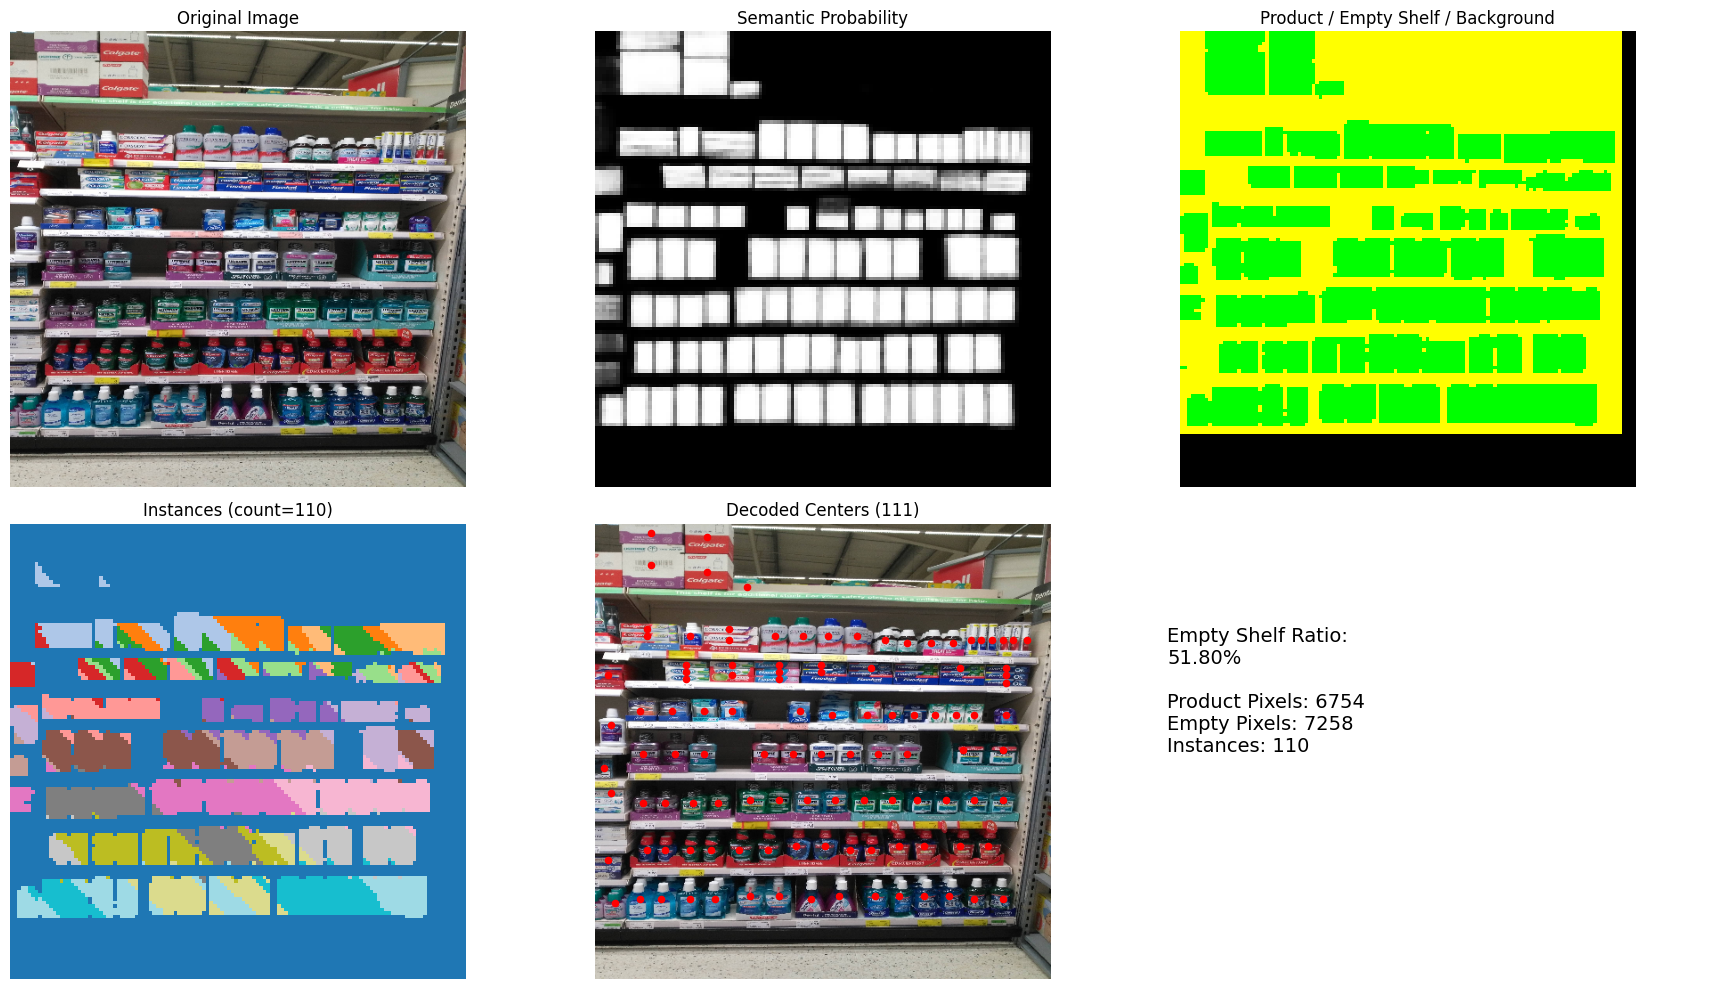


--- Inference Summary ---
Decoded centers      : 111
Predicted instances  : 110
Product pixels       : 6754
Empty shelf pixels   : 7258
Empty shelf ratio    : 51.80%


In [42]:
# ============================================================
# FULL INFERENCE OUTPUT VISUALIZATION
# ============================================================

import matplotlib.pyplot as plt

# --- Run inference ---
result = run_full_inference("test_14.jpg")

img            = result["image"]              # [3,512,512]
sem_prob       = result["sem_prob"]           # [Hf,Wf]
product_mask   = result["product_mask"]
empty_mask     = result["empty_mask"]
background     = result["background_mask"]
instance_map   = result["instance_map"]
centers        = result["centers"]
empty_ratio    = result["empty_ratio"]

# ============================================================
# RGB Overlay (Product / Empty / Background)
# ============================================================

viz = torch.zeros((*product_mask.shape, 3), dtype=torch.float32)

# product → green
viz[product_mask] = torch.tensor([0.0, 1.0, 0.0], dtype=torch.float32)

# empty shelf → yellow
viz[empty_mask] = torch.tensor([1.0, 1.0, 0.0], dtype=torch.float32)

# background → black (implicit)

# ============================================================
# Plot everything
# ============================================================

plt.figure(figsize=(18,10))

# Original image
plt.subplot(2,3,1)
plt.imshow(img.permute(1,2,0))
plt.title("Original Image")
plt.axis("off")

# Semantic probability
plt.subplot(2,3,2)
plt.imshow(sem_prob, cmap="gray")
plt.title("Semantic Probability")
plt.axis("off")

# Shelf segmentation
plt.subplot(2,3,3)
plt.imshow(viz)
plt.title("Product / Empty Shelf / Background")
plt.axis("off")

# Instance map
plt.subplot(2,3,4)
plt.imshow(instance_map, cmap="tab20")
plt.title(f"Instances (count={instance_map.unique().numel()-1})")
plt.axis("off")

# Centers overlay
plt.subplot(2,3,5)
plt.imshow(img.permute(1,2,0))
plt.axis("off")
for c in centers:
    x, y = c[:2]          # ignore score if present
    x = x.item() if torch.is_tensor(x) else float(x)
    y = y.item() if torch.is_tensor(y) else float(y)
    plt.scatter(x, y, c="red", s=20)

plt.title(f"Decoded Centers ({len(centers)})")

# Empty shelf ratio text
plt.subplot(2,3,6)
plt.text(
    0.1, 0.5,
    f"Empty Shelf Ratio:\n{empty_ratio:.2%}\n\n"
    f"Product Pixels: {product_mask.sum().item()}\n"
    f"Empty Pixels: {empty_mask.sum().item()}\n"
    f"Instances: {instance_map.unique().numel()-1}",
    fontsize=14
)
plt.axis("off")

plt.tight_layout()
plt.show()

# ============================================================
# Console Diagnostics
# ============================================================

print("\n--- Inference Summary ---")
print(f"Decoded centers      : {len(centers)}")
print(f"Predicted instances  : {instance_map.unique().numel() - 1}")
print(f"Product pixels       : {int(product_mask.sum())}")
print(f"Empty shelf pixels   : {int(empty_mask.sum())}")
print(f"Empty shelf ratio    : {empty_ratio:.2%}")
